In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([1.0, 0.7]), 'fb': np.array([0.15, 0.15])}

neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 30
hopfield_g = 0.5
use_random_sign_beta = True
use_three_phase = False
weight_decay = False


model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

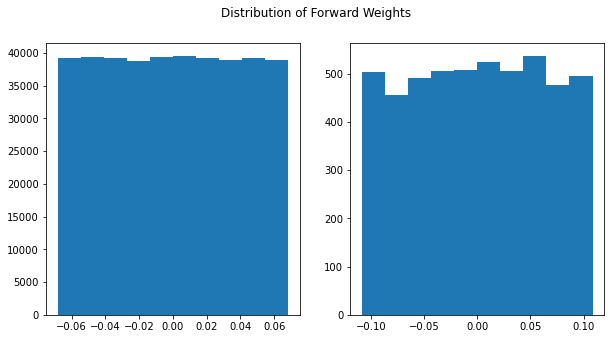

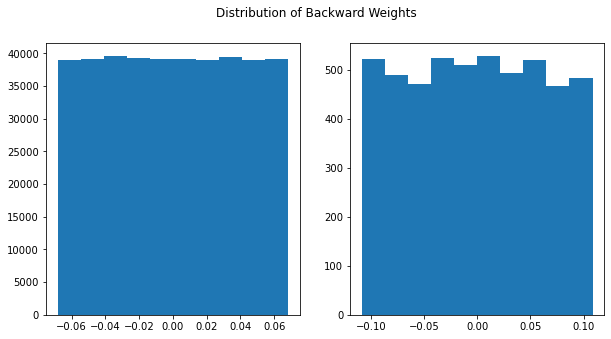

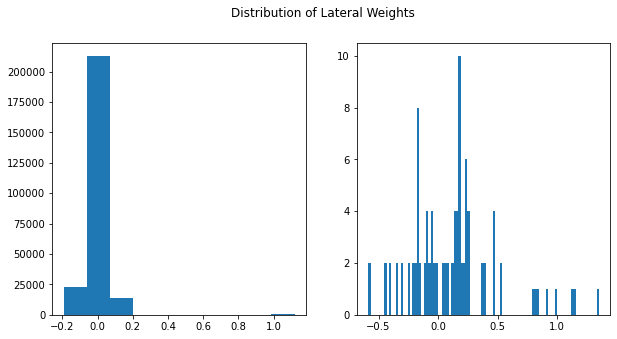

In [5]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wff[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wff[1]['weight']).reshape(-1,1))
plt.suptitle("Distribution of Forward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wfb[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wfb[1]['weight']).reshape(-1,1))
plt.suptitle("Distribution of Backward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.B[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.B[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Lateral Weights")
plt.show()

In [6]:
_ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                          neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.09323333333333333


In [7]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 50

for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [01:57, 25.44it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.9428, Test Accuracy : 0.9431


3000it [01:58, 25.40it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.9622, Test Accuracy : 0.958


3000it [01:57, 25.43it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.96765, Test Accuracy : 0.9615


3000it [01:57, 25.50it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.9711166666666666, Test Accuracy : 0.9646


3000it [01:57, 25.60it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.9778166666666667, Test Accuracy : 0.97


3000it [01:57, 25.55it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.9799666666666667, Test Accuracy : 0.9718


3000it [01:57, 25.42it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.9827166666666667, Test Accuracy : 0.9713


3000it [01:58, 25.35it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.9828833333333333, Test Accuracy : 0.9712


3000it [01:58, 25.41it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.9844, Test Accuracy : 0.9741


3000it [01:57, 25.61it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.9855166666666667, Test Accuracy : 0.9751


3000it [01:57, 25.62it/s]
0it [00:00, ?it/s]

Epoch : 11, Train Accuracy : 0.9864833333333334, Test Accuracy : 0.9753


3000it [01:57, 25.62it/s]
0it [00:00, ?it/s]

Epoch : 12, Train Accuracy : 0.9863333333333333, Test Accuracy : 0.975


3000it [01:57, 25.51it/s]
0it [00:00, ?it/s]

Epoch : 13, Train Accuracy : 0.9865333333333334, Test Accuracy : 0.9751


3000it [01:57, 25.45it/s]
0it [00:00, ?it/s]

Epoch : 14, Train Accuracy : 0.9877333333333334, Test Accuracy : 0.9759


3000it [01:56, 25.78it/s]
0it [00:00, ?it/s]

Epoch : 15, Train Accuracy : 0.9881666666666666, Test Accuracy : 0.9759


3000it [01:56, 25.81it/s]
0it [00:00, ?it/s]

Epoch : 16, Train Accuracy : 0.9886666666666667, Test Accuracy : 0.9753


3000it [01:55, 25.92it/s]
0it [00:00, ?it/s]

Epoch : 17, Train Accuracy : 0.9883166666666666, Test Accuracy : 0.975


3000it [01:55, 25.89it/s]
0it [00:00, ?it/s]

Epoch : 18, Train Accuracy : 0.98865, Test Accuracy : 0.9753


3000it [01:56, 25.84it/s]
0it [00:00, ?it/s]

Epoch : 19, Train Accuracy : 0.9888666666666667, Test Accuracy : 0.9749


3000it [01:56, 25.80it/s]
0it [00:00, ?it/s]

Epoch : 20, Train Accuracy : 0.9885833333333334, Test Accuracy : 0.9754


3000it [01:55, 25.88it/s]
0it [00:00, ?it/s]

Epoch : 21, Train Accuracy : 0.9888833333333333, Test Accuracy : 0.9757


3000it [01:55, 25.90it/s]
0it [00:00, ?it/s]

Epoch : 22, Train Accuracy : 0.98895, Test Accuracy : 0.9752


3000it [01:55, 25.98it/s]
0it [00:00, ?it/s]

Epoch : 23, Train Accuracy : 0.9889, Test Accuracy : 0.9762


3000it [01:55, 26.02it/s]
0it [00:00, ?it/s]

Epoch : 24, Train Accuracy : 0.9890333333333333, Test Accuracy : 0.9758


3000it [01:55, 25.92it/s]
0it [00:00, ?it/s]

Epoch : 25, Train Accuracy : 0.9892166666666666, Test Accuracy : 0.9747


3000it [01:56, 25.82it/s]
0it [00:00, ?it/s]

Epoch : 26, Train Accuracy : 0.9891166666666666, Test Accuracy : 0.9758


3000it [01:54, 26.16it/s]
0it [00:00, ?it/s]

Epoch : 27, Train Accuracy : 0.9892, Test Accuracy : 0.9756


3000it [01:55, 25.91it/s]
0it [00:00, ?it/s]

Epoch : 28, Train Accuracy : 0.9891833333333333, Test Accuracy : 0.9759


3000it [01:55, 25.96it/s]
0it [00:00, ?it/s]

Epoch : 29, Train Accuracy : 0.9892, Test Accuracy : 0.9756


3000it [01:55, 25.88it/s]
0it [00:00, ?it/s]

Epoch : 30, Train Accuracy : 0.9893, Test Accuracy : 0.9756


3000it [01:56, 25.80it/s]
0it [00:00, ?it/s]

Epoch : 31, Train Accuracy : 0.9891333333333333, Test Accuracy : 0.9759


3000it [01:56, 25.80it/s]
0it [00:00, ?it/s]

Epoch : 32, Train Accuracy : 0.9892833333333333, Test Accuracy : 0.9756


3000it [01:55, 25.87it/s]
0it [00:00, ?it/s]

Epoch : 33, Train Accuracy : 0.9892833333333333, Test Accuracy : 0.9757


3000it [01:55, 25.90it/s]
0it [00:00, ?it/s]

Epoch : 34, Train Accuracy : 0.9892833333333333, Test Accuracy : 0.9757


3000it [01:55, 25.98it/s]
0it [00:00, ?it/s]

Epoch : 35, Train Accuracy : 0.9892666666666666, Test Accuracy : 0.976


3000it [01:55, 25.96it/s]
0it [00:00, ?it/s]

Epoch : 36, Train Accuracy : 0.9893333333333333, Test Accuracy : 0.9756


3000it [01:55, 25.87it/s]
0it [00:00, ?it/s]

Epoch : 37, Train Accuracy : 0.98925, Test Accuracy : 0.9756


3000it [01:54, 26.22it/s]
0it [00:00, ?it/s]

Epoch : 38, Train Accuracy : 0.9894, Test Accuracy : 0.9757


3000it [01:56, 25.86it/s]
0it [00:00, ?it/s]

Epoch : 39, Train Accuracy : 0.9892333333333333, Test Accuracy : 0.9758


3000it [01:55, 25.97it/s]
0it [00:00, ?it/s]

Epoch : 40, Train Accuracy : 0.9892666666666666, Test Accuracy : 0.9755


3000it [01:55, 25.98it/s]
0it [00:00, ?it/s]

Epoch : 41, Train Accuracy : 0.9893, Test Accuracy : 0.9759


3000it [01:55, 25.93it/s]
0it [00:00, ?it/s]

Epoch : 42, Train Accuracy : 0.9893, Test Accuracy : 0.9759


3000it [01:55, 25.88it/s]
0it [00:00, ?it/s]

Epoch : 43, Train Accuracy : 0.9893, Test Accuracy : 0.9758


3000it [01:04, 46.74it/s]
1it [00:00,  5.70it/s]

Epoch : 44, Train Accuracy : 0.9893166666666666, Test Accuracy : 0.9758


3000it [00:56, 52.73it/s]
0it [00:00, ?it/s]

Epoch : 45, Train Accuracy : 0.9893666666666666, Test Accuracy : 0.9758


3000it [01:55, 25.91it/s]
1it [00:00,  5.89it/s]

Epoch : 46, Train Accuracy : 0.9894, Test Accuracy : 0.9756


3000it [00:57, 52.36it/s]
1it [00:00,  6.01it/s]

Epoch : 47, Train Accuracy : 0.9893666666666666, Test Accuracy : 0.9758


3000it [00:57, 52.59it/s]
1it [00:00,  5.70it/s]

Epoch : 48, Train Accuracy : 0.9893166666666666, Test Accuracy : 0.9758


3000it [00:56, 52.79it/s]
1it [00:00,  5.67it/s]

Epoch : 49, Train Accuracy : 0.9893333333333333, Test Accuracy : 0.9757


3000it [00:58, 51.63it/s]


Epoch : 50, Train Accuracy : 0.9893333333333333, Test Accuracy : 0.9756


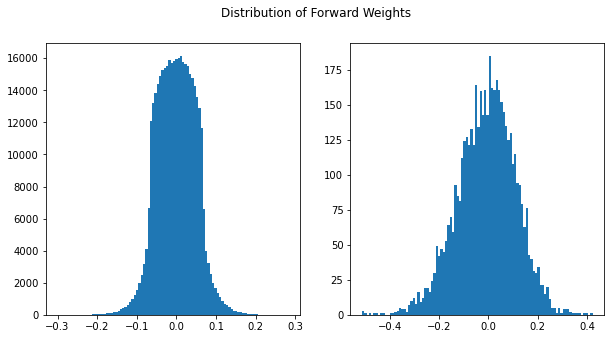

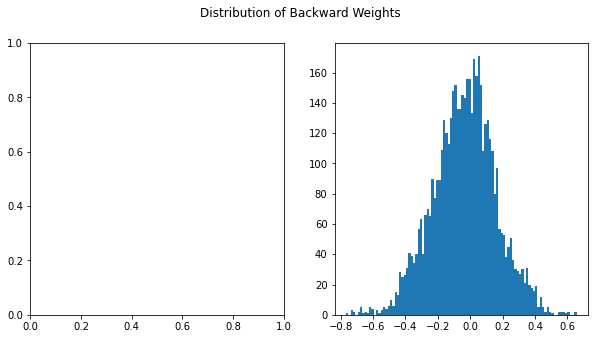

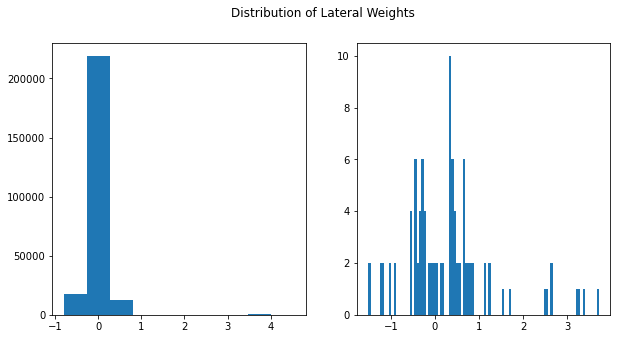

In [8]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wff[0]['weight']).reshape(-1,1),bins = 100)
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wff[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Forward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
# plt.hist(torch2numpy(model.Wfb[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wfb[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Backward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.B[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.B[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Lateral Weights")
plt.show()

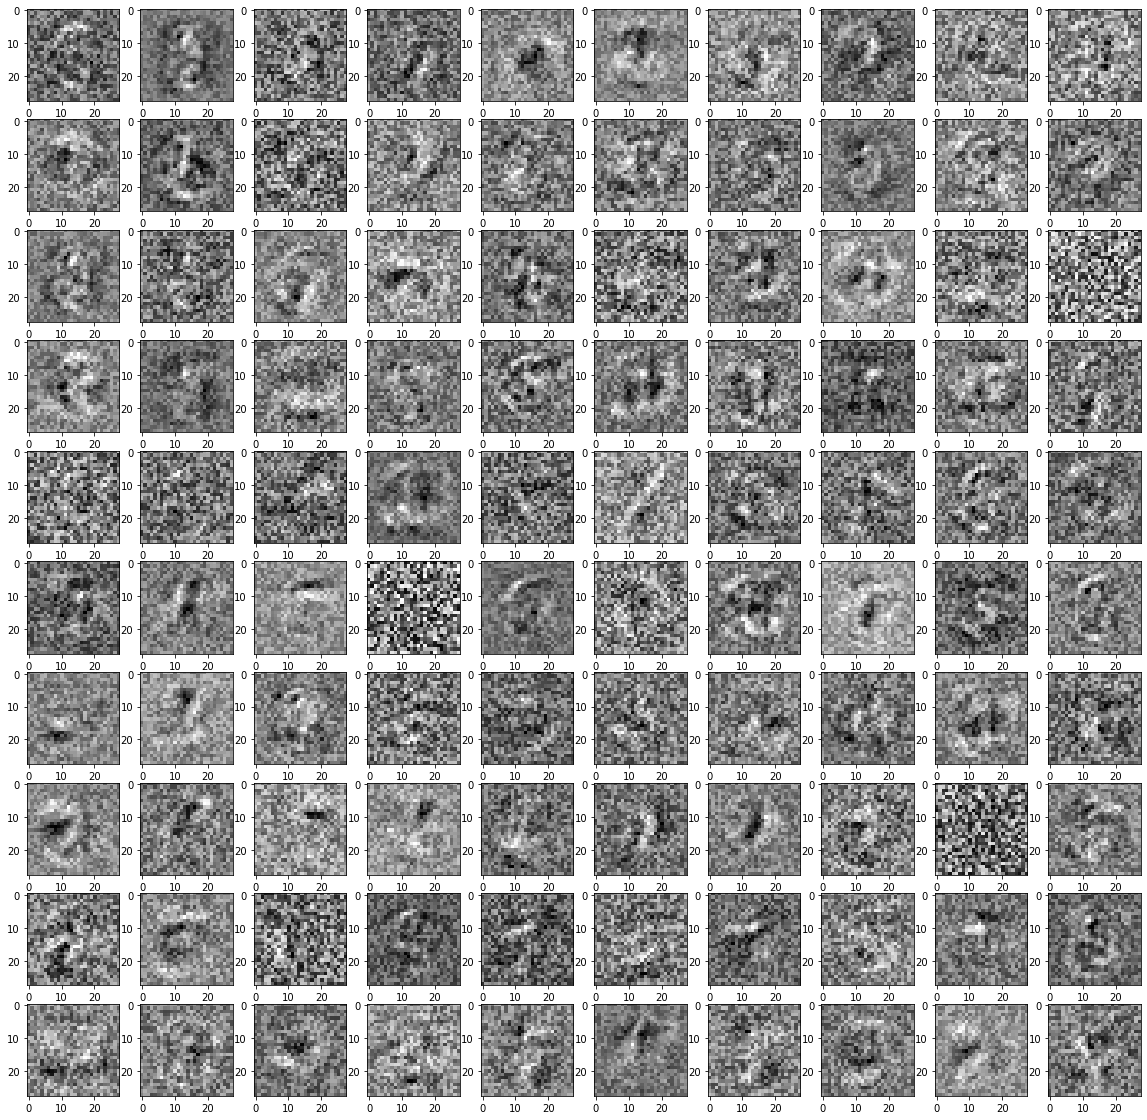

In [9]:
indices = np.random.choice(500, 100, replace = False)
plt.figure(figsize = (20,20))
for plt_idx, idx in enumerate(indices):
    plt.subplot(10, 10, plt_idx + 1)
    plt.imshow(torch2numpy(model.Wff[0]['weight'])[idx,:].reshape(28,28), cmap = "gray")
#     plt.axes().get_xaxis().set_visible(False)
#     plt.axes().get_yaxis().set_visible(False)

In [10]:
hidden_layer_list = []
ground_truth_list = []
for x, y in test_loader:
    x = x.view(x.size(0),-1).to(device).T
    y = y.to(device)

    neurons = model.init_neurons(x.size(1), device = model.device)

    # dynamics for T time steps
    neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, 
                                                       hopfield_g, 
                                                       neural_lr_start, 
                                                       neural_lr_stop, 
                                                       neural_lr_rule, 
                                                       neural_lr_decay_multiplier, 
                                                       neural_dynamic_iterations_free,
                                                       beta = 0) 
    hidden_layer_list.append(neurons[0])
    ground_truth_list.append(y)
    
hidden_layer_list = torch.concat(hidden_layer_list, axis = 1)
ground_truth_list = torch.concat(ground_truth_list)

In [11]:
from sklearn.manifold import TSNE

In [12]:
tsne_result = TSNE(n_components=2).fit_transform(torch2numpy(hidden_layer_list).T)

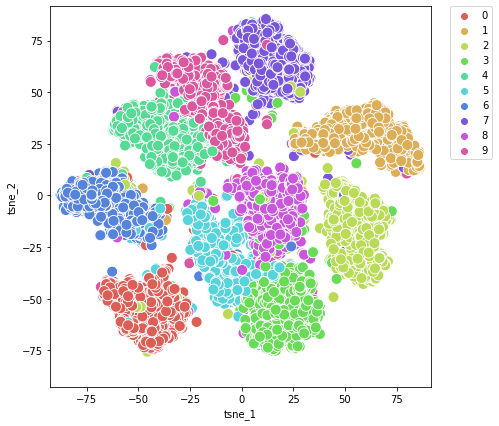

In [13]:
import seaborn as sns
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': torch2numpy(ground_truth_list)})
fig, ax = plt.subplots(1, figsize = (7,7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, palette=sns.color_palette("hls", 10), ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

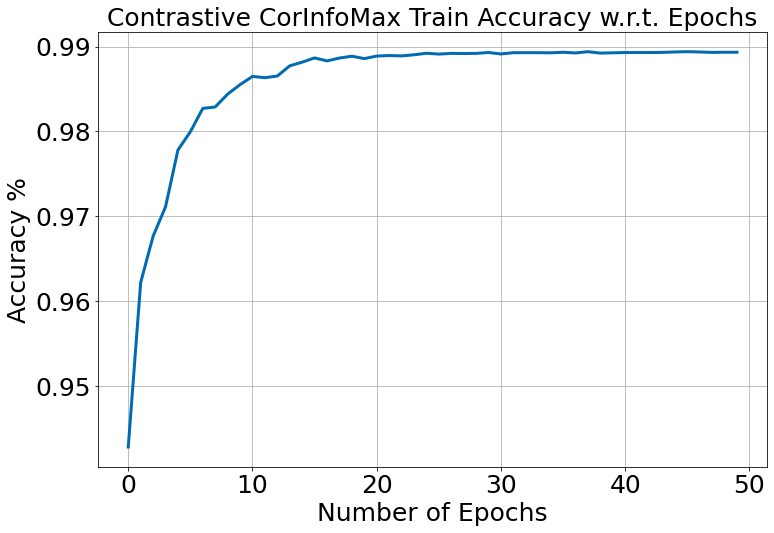

In [14]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

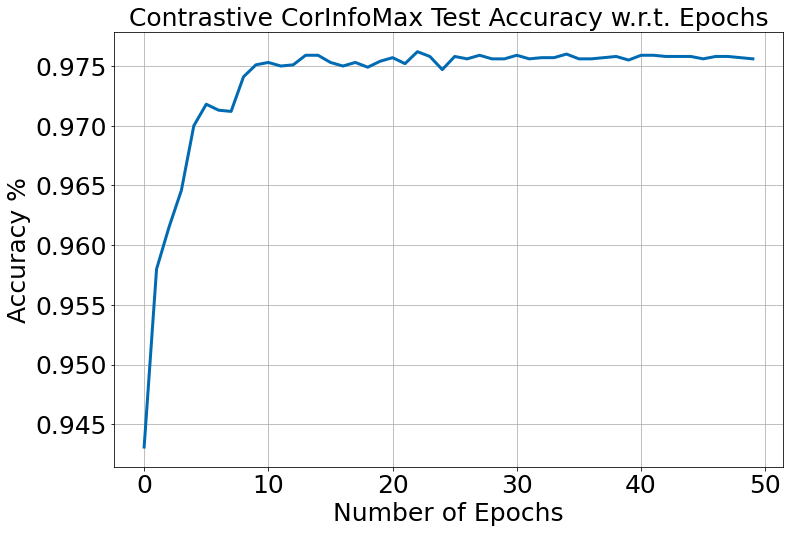

In [15]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

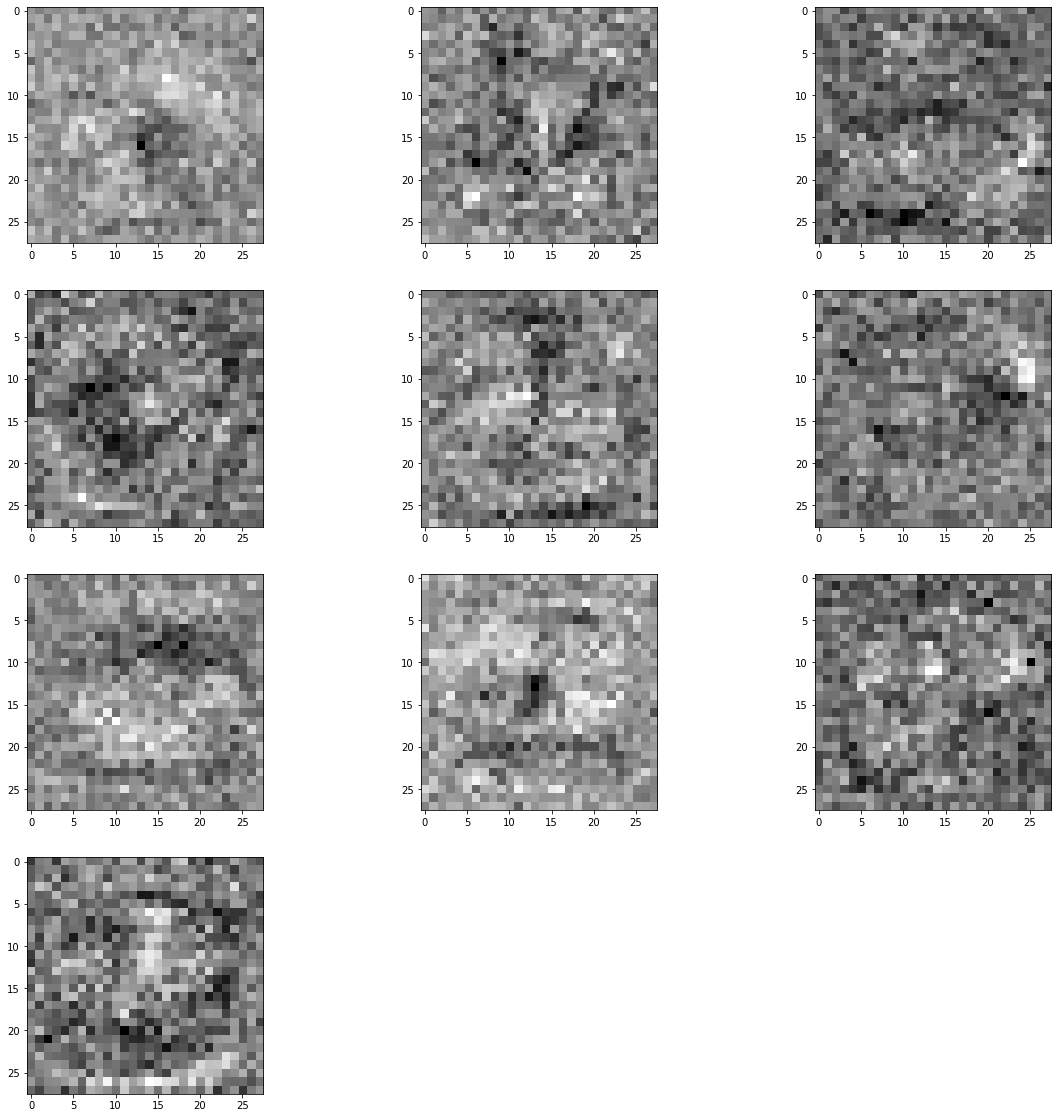

In [16]:
indices = np.arange(10)
plt.figure(figsize = (20,20))
myW = (model.Wff[1]['weight'] @ model.Wff[0]['weight'])
for plt_idx, idx in enumerate(indices):
    plt.subplot(4, 3, plt_idx + 1)
    plt.imshow(torch2numpy(myW)[idx,:].reshape(28,28), cmap = "gray")
#     plt.axes().get_xaxis().set_visible(False)
#     plt.axes().get_yaxis().set_visible(False)